In [1]:
import glob
import scipy.interpolate
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [43]:

##Load smearing data from IceCube
data_file = "./data/IC86_II_smearing.csv"
e_nu = np.array([])
e_mu = np.array([])
dec = np.array([])
frac = np.array([])
df = pd.DataFrame()    
df = pd.concat([df, pd.read_fwf(data_file, header=None, skiprows=1)])

e_nu = (df[0].to_numpy()+df[1].to_numpy())/2
e_mu = (df[4].to_numpy()+df[5].to_numpy())/2
dec =  (df[2].to_numpy()+df[3].to_numpy())/2
frac = (df[10].to_numpy())

e_nu = np.delete(e_nu, e_mu==0)
dec = np.delete(dec, e_mu==0)
e_mu = np.delete(e_mu, e_mu==0)
frac = np.delete(frac, e_mu==0)

##Load fake neutrino data
icecube_data = np.load("./processed_data/energy_cut_data.npz",
                       allow_pickle=True)
data_dec = np.array(icecube_data["data_dec"])
data_eng = np.array(icecube_data["data_eng"])
data_ra = np.array(icecube_data["data_ra"])
data_sigmas = np.array(icecube_data["data_sigmas"])


##Break up the neutrino data in terms of the different regions of the sky
north_eng = np.zeros(len(data_eng[data_dec>=10]))
horizon_eng = np.zeros(len(data_eng[np.logical_and(data_dec>=-10,data_dec<10)]))
south_eng = np.zeros(len(data_eng[data_dec>=10]))

north_eng = data_eng[data_dec>=10]
horizon_eng = data_eng[np.logical_and(data_dec>=-10,data_dec<10)]
south_eng = data_eng[data_dec< -10]

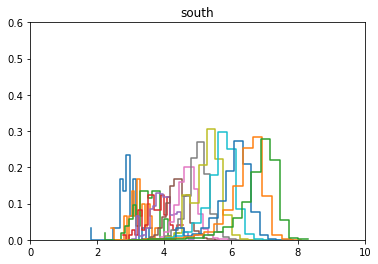

In [45]:

##Find the indices of the smearing data of the south, and set new variables of neutrino, muon, and fractional
##data for those indices. Lim is the average of the bounds for neutrino energy


index = []
for i in range(len(dec)):
    if dec[i]<-10:
        index.insert(len(index),i)
lim = [2.25,2.75,3.25,3.75,4.25,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25]
regional_e_mu = e_mu[index]
regional_e_nu = e_nu[index]
regional_frac = frac[index]




##Here I define variables of the unique muon energy bins in the IceCube data (mainly for plot recreation)
##Then, I define total_frac, which sums over the fractional value of each individual data point. 
##Next is new_e_mu, which is where I will store the muon energy converted from neutrino energy.
##Muon is the linspace to create the function over, where the bounds are the min and max of the distribution given

unique_mu = np.zeros((13,20))
total_frac = np.zeros((13,20))
new_e_mu = np.zeros(len(south_eng))
lower_bound = [2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0]
upper_bound = [2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5]
muon = np.zeros((13,1000))

for k in range(len(lim)):
    unique_mu[k] = np.unique(regional_e_mu[regional_e_nu==lim[k]])
    for i, unique in enumerate(unique_mu[k]):
        total_frac[k][i] = np.sum(regional_frac[unique==regional_e_mu])
        
    plt.step(unique_mu[k],total_frac[k])
    plt.xlim(0,10)
    plt.ylim(0,0.6)
    plt.title("south")
    muon[k]=np.linspace(np.min(unique_mu[k]),np.max(unique_mu[k]),1000)
    func = scipy.interpolate.interp1d(unique_mu[k], total_frac[k], bounds_error=False, fill_value=0)
    new_e_mu[np.logical_and(south_eng<upper_bound[k],south_eng>=lower_bound[k])] = np.random.choice(muon[k],
                                                                                                      p = (func(muon[k])/np.sum(func(muon[k]))),
                                                                                                      size = len(new_e_mu[np.logical_and(south_eng<upper_bound[k],south_eng>=lower_bound[k])]))

data_eng[data_dec<-10] = new_e_mu

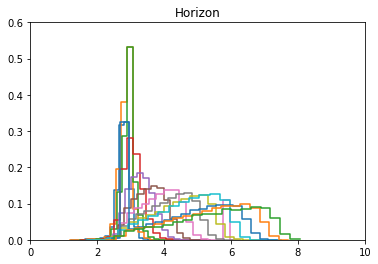

In [46]:

##Find the indices of the smearing data of the Horizon, and set new variables of neutrino, muon, and fractional
##data for those indices. Lim is the average of the bounds for neutrino energy


index = []
for i in range(len(dec)):
    if np.logical_and(dec[i]>= -10, dec[i]<10):
        index.insert(len(index),i)
lim = [2.25,2.75,3.25,3.75,4.25,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25]
regional_e_mu = e_mu[index]
regional_e_nu = e_nu[index]
regional_frac = frac[index]




##Here I define variables of the unique muon energy bins in the IceCube data (mainly for plot recreation)
##Then, I define total_frac, which sums over the fractional value of each individual data point. 
##Next is new_e_mu, which is where I will store the muon energy converted from neutrino energy.
##Muon is the linspace to create the function over, where the bounds are the min and max of the distribution given

unique_mu = np.zeros((13,20))
total_frac = np.zeros((13,20))
new_e_mu = np.zeros(len(horizon_eng))
lower_bound = [2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0]
upper_bound = [2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5]
muon = np.zeros((13,1000))

for k in range(len(lim)):
    unique_mu[k] = np.unique(regional_e_mu[regional_e_nu==lim[k]])
    for i, unique in enumerate(unique_mu[k]):
        total_frac[k][i] = np.sum(regional_frac[unique==regional_e_mu])
        
    plt.step(unique_mu[k],total_frac[k])
    plt.xlim(0,10)
    plt.ylim(0,0.6)
    plt.title("Horizon")
    muon[k]=np.linspace(np.min(unique_mu[k]),np.max(unique_mu[k]),1000)
    func = scipy.interpolate.interp1d(unique_mu[k], total_frac[k], bounds_error=False, fill_value=0)
    new_e_mu[np.logical_and(horizon_eng<upper_bound[k],horizon_eng>=lower_bound[k])] = np.random.choice(muon[k],
                                                                                                      p = (func(muon[k])/np.sum(func(muon[k]))),
                                                                                                      size = len(new_e_mu[np.logical_and(horizon_eng<upper_bound[k],horizon_eng>=lower_bound[k])]))

data_eng[np.logical_and(data_dec>= -10,data_dec<10)] = new_e_mu


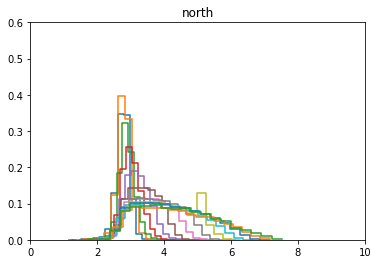

In [47]:
index = []
for i in range(len(dec)):
    if dec[i] >=10:
        index.insert(len(index),i)
lim = [2.25,2.75,3.25,3.75,4.25,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25]
regional_e_mu = e_mu[index]
regional_e_nu = e_nu[index]
regional_frac = frac[index]




##Here I define variables of the unique muon energy bins in the IceCube data (mainly for plot recreation)
##Then, I define total_frac, which sums over the fractional value of each individual data point. 
##Next is new_e_mu, which is where I will store the muon energy converted from neutrino energy.
##Muon is the linspace to create the function over, where the bounds are the min and max of the distribution given

unique_mu = np.zeros((13,20))
total_frac = np.zeros((13,20))
new_e_mu = np.zeros(len(north_eng))
lower_bound = [2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0]
upper_bound = [2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5]
muon = np.zeros((13,1000))

for k in range(len(lim)):
    unique_mu[k] = np.unique(regional_e_mu[regional_e_nu==lim[k]])
    for i, unique in enumerate(unique_mu[k]):
        total_frac[k][i] = np.sum(regional_frac[unique==regional_e_mu])
        
    plt.step(unique_mu[k],total_frac[k])
    plt.xlim(0,10)
    plt.ylim(0,0.6)
    plt.title("north")
    muon[k]=np.linspace(np.min(unique_mu[k]),np.max(unique_mu[k]),1000)
    func = scipy.interpolate.interp1d(unique_mu[k], total_frac[k], bounds_error=False, fill_value=0)
    new_e_mu[np.logical_and(north_eng<upper_bound[k],north_eng>=lower_bound[k])] = np.random.choice(muon[k],
                                                                                                      p = (func(muon[k])/np.sum(func(muon[k]))),
                                                                                                      size = len(new_e_mu[np.logical_and(north_eng<upper_bound[k],north_eng>=lower_bound[k])]))

data_eng[data_dec>=10] = new_e_mu

In [49]:
np.savez("./processed_data/energy_cut_data.npz",
         data_sigmas = data_sigmas,
         data_ra= data_ra,
         data_dec=data_dec,
         data_eng = data_eng) 